This project focuses on predicting of final amount of points for all teams in English Premier League in season 2022-2023. So basically we can learn who might finish on the first spot and win the title and who will finish in top 4 or top 6, based on current performance of the teams.

DISCLAIMER: Once I again I used some code structures and ideas from these sources (https://github.com/dataquestio/project-walkthroughs/blob/master/football_matches/scraping.ipynb,  https://www.kaggle.com/code/moe5998/car-price-prediction-eda-ml-regression-models/notebook)



In [1]:
import requests
from bs4 import BeautifulSoup
import time
import re
from urllib.request import urlopen
from urllib.request import Request
from urllib.error import URLError
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split

For the prediction of the winner I need to look at current performance of the teams in this season and look at earlier seasons' performances and how many points those kind of performances brought in the end. So for sure I need to know points for earlier seasons and also things that influence the number of points meaning how good teams played during earlier seasons. I consider xG stats and stats that show how good a team plays in offense as the stats that influence number of wins and points the most. In further projects it will be a good idea to include pressing stats into prediction process because quality of pressing nowadays plays a big role in overall performance of a team. 

We start with Web Scraping of the FBRef website where I found the stats I needed for the prediction. I had to do the scraping in 4 steps and add significant timesleep as 10 sec just to be sure that FBRef won't bann me for an hour.

In [4]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(10)

In [5]:
ttable = pd.concat(all_matches)

In [ ]:
ttable = ttable.astype({'GF':'int'})
ttable = ttable.astype({'GA':'int'})
ttable=ttable.reset_index()
ttable.drop('index',axis=1,inplace=True)

In [7]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/passing/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        passing = pd.read_html(data.text, match="Passing")[0]
        passing.columns = passing.columns.droplevel()
        
        try:
            team_data1 = matches.merge(passing[["Date", "KP", "1/3", "PPA", "CrsPA", "Prog"]], on="Date")
        except ValueError:
            continue 
        team_data1 = team_data1[team_data1["Comp"] == "Premier League"]
        
        team_data1["Season"] = year
        team_data1["Team"] = team_name
        all_matches.append(team_data1)
        time.sleep(10)

In [8]:
assists = pd.concat(all_matches)
assists=assists.reset_index()
assists.drop('index',axis=1,inplace=True)

In [11]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/possession/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        possession = pd.read_html(data.text, match="Possession")[0]
        possession.columns = possession.columns.droplevel()
        
        try:
            team_data2= matches.merge(possession[["Date", "Att 3rd", "Att Pen", "Prog"]], on="Date")
        except ValueError:
            continue  
        team_data2 = team_data2[team_data2["Comp"] == "Premier League"]
                
        team_data2["Season"] = year
        team_data2["Team"] = team_name
        all_matches.append(team_data2)
        time.sleep(10)

In [12]:
posses = pd.concat(all_matches)
posses=posses.reset_index()
posses.drop('index',axis=1,inplace=True)

In [14]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/gca/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        gfc = pd.read_html(data.text, match="Goal and Shot Creation")[0]
        gfc.columns = gfc.columns.droplevel()
        
        try:
            team_data3 = matches.merge(gfc[["Date", "SCA"]], on="Date")
        except ValueError:
            continue  
        team_data3 = team_data3[team_data3["Comp"] == "Premier League"]    
        
                
        team_data3["Season"] = year
        team_data3["Team"] = team_name
        all_matches.append(team_data3)
        time.sleep(10)

In [15]:
creation = pd.concat(all_matches)
creation=creation.reset_index()
creation.drop('index',axis=1,inplace=True)

In [17]:
years = list(range(2022, 2016, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/passing_types/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        passing_type = pd.read_html(data.text, match="Pass Types")[0]
        passing_type.columns = passing_type.columns.droplevel()
        
        try:
            team_data5 = matches.merge(passing_type[["Date", "TB"]], on="Date")
        except ValueError:
            continue
        team_data5 = team_data5[team_data5["Comp"] == "Premier League"]   
        
                
        team_data5["Season"] = year
        team_data5["Team"] = team_name
        all_matches.append(team_data5)
        time.sleep(10)

In [18]:
back1=pd.concat(all_matches)
back1=back1.reset_index()
back1.drop('index',axis=1,inplace=True)

Let me explain the stats:
Main stats
xG - expected goals
xGA - expected allowed goals
Poss - possession of the ball
GF - goals scored
GA - goals allowed

Shooting stats
"Sh" - total number of shots
"SoT" - shots on target
"Dist" - average distance in yards from goal of all shots taken
"FK" - shots from free kicks
"PK" - penalty kicks made
"PKatt" - penalty kicks attempted

Passing stats
"KP" - passes that directly lead to a shot
"1/3" - completed passes that enter the final third of the pitch on offense
"PPA" - completed passes into the 18-yard box not including set pieces
"CrsPA" - completed crosse into the 18-yard box
"Prog" - progressive passes, completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area.

Possession stats
"Att 3rd" - touches in attacking third of the pitch
"Att Pen" - touches in attacking penalty area
"Prog" - progressive passes recieved, completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area.

Goal and Shot Creation stats
"SCA" - shot-creating actions, the two offensive actions directly leading to a shot such as passes, dribbles and drawing fouls.

Pass type stats
"TB" - completed pass sent between back defenders into open space.



Okay, so I have 5 dataframes with all fixtures of every team for the current season and previous 5 seasons. The point is to calculate averages of features for every team in every season. By averages of features I mean for example average of xG per game or how many times on average a team passes into the final third during the season.

I made a "season" function that gives back a dataframe with averages of all features for every team in certain season.

In [27]:
def season(x):
    
    mainseas=ttable[ttable['Season']==x]
    ass=assists[assists['Season']==x]
    poss=posses[posses['Season']==x]
    cre=creation[creation['Season']==x]
    back=back1[back1['Season']==x]
    
    
    
    feat=["Sh", "SoT", "Dist", "FK", "PK", "PKatt",'GF','GA','xG','xGA','Poss',"KP", "1/3", "PPA", "CrsPA", "Prog","Att 3rd", "Att Pen", "Prog",'SCA','TB']
    df=pd.DataFrame()
    df['Team']=mainseas['Team'].unique()
    for i in feat:
        df[i]=0.0
        
    main=["Sh", "SoT", "Dist", "FK", "PK", "PKatt",'GF','GA','xG','xGA','Poss']
    asss=["KP", "1/3", "PPA", "CrsPA", "Prog"]
    posss=["Att 3rd", "Att Pen", "Prog"]
    gfc=['SCA']
    tb=['TB']
    feat1=[main,asss,poss,gfc,tb]
    tables=[mainseas,ass,poss,cre,back]
    
    
    
    for j in main:
        for i in range(len(df)):
            df[j][i]=mainseas[mainseas['Team']==df['Team'][i]][j].mean()
                
                
    for j in asss:
        for i in range(len(df)):
            df[j][i]=ass[ass['Team']==df['Team'][i]][j].mean()
                
    for j in posss:
        for i in range(len(df)):
            df[j][i]=poss[poss['Team']==df['Team'][i]][j].mean()
    
    for i in range(len(df)):
        df['SCA'][i]=cre[cre['Team']==df['Team'][i]]['SCA'].mean()
    
    for i in range(len(df)):
        df['TB'][i]=back[back['Team']==df['Team'][i]]['TB'].mean()
            
            
    df['Season']=x
    df['Points']=0
    df['Points per match']=0.0
    for i in range(len(df)):
        df['Points'][i]=mainseas[mainseas['Team']==df['Team'][i]]['Result'].value_counts()['W']*3+mainseas[mainseas['Team']==df['Team'][i]]['Result'].value_counts()['D']
    for i in range(len(df)):
        df['Points per match'][i]=(df['Points'][i])/(len(mainseas[mainseas['Team']==df['Team'][i]]))
    
    
    return df    

In [ ]:
seas20=season(2020)
seas19=season(2019)
seas22=season(2022)
seas17=season(2017)
seas18=season(2018)
seas21=season(2021)

In [318]:
total=pd.concat([seas19,seas20,seas21,seas17,seas18])

So we got a merged table consisting of tables for 5 seasons. I will add the code lines in which I read all the stats from csv files that I made beforehand. I am doing this in order to run this code on Kaggle in a faster way than it would run with scraping the web page.

In [ ]:
total=pd.read_csv('table_for_5_seasons.csv')
seas22=pd.read_csv('seas22_clear.csv')
fix=pd.read_csv('all_fixtures_with_str_result.csv')

In [109]:
total

,Team,Sh,SoT,Dist,FK,PK,PKatt,GF,GA,xG,...,PPA,CrsPA,Prog,Att 3rd,Att Pen,SCA,TB,Season,Points,Points per match
0,Manchester City,17.263158,6.684211,17.805263,0.789474,0.157895,0.210526,2.789474,0.710526,2.065789,...,13.815789,1.157895,45.447368,253.605263,32.894737,31.815789,3.105263,2017,100,2.631579
1,Manchester United,13.394737,4.473684,18.055263,0.552632,0.026316,0.078947,1.789474,0.736842,1.468421,...,9.394737,1.921053,30.736842,185.026316,23.447368,24.105263,2.236842,2017,81,2.131579
2,Tottenham Hotspur,16.315789,5.500000,18.568421,0.736842,0.052632,0.078947,1.947368,0.947368,1.700000,...,10.368421,1.657895,43.421053,194.184211,24.684211,28.710526,2.184211,2017,77,2.026316
3,Liverpool,16.710526,5.947368,17.600000,0.578947,0.052632,0.078947,2.210526,1.000000,1.913158,...,12.210526,1.763158,45.657895,189.710526,27.789474,29.947368,2.789474,2017,75,1.973684
4,Chelsea,15.868421,5.526316,17.518421,0.526316,0.078947,0.078947,1.631579,1.000000,1.423684,...,10.473684,1.947368,36.710526,190.921053,26.105263,29.342105,1.815789,2017,70,1.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Everton,11.315789,3.421053,17.918421,0.473684,0.157895,0.184211,1.131579,1.736842,1.250000,...,6.710526,2.026316,20.631579,129.789474,19.078947,19.500000,0.789474,2021,39,1.026316
96,Leeds United,12.631579,3.736842,18.552632,0.342105,0.131579,0.131579,1.105263,2.078947,1.328947,...,7.157895,1.394737,28.342105,127.447368,20.526316,21.684211,1.736842,2021,38,1.000000
97,Burnley,10.657895,3.131579,17.452632,0.368421,0.026316,0.052632,0.894737,1.394737,1.152632,...,6.315789,2.210526,18.631579,122.078947,17.342105,17.736842,0.842105,2021,35,0.921053
98,Watford,10.447368,3.236842,18.302632,0.631579,0.026316,0.052632,0.894737,2.026316,1.163158,...,5.605263,1.842105,19.842105,112.394737,16.078947,18.210526,0.921053,2021,23,0.605263


Let's look at correlations between features.

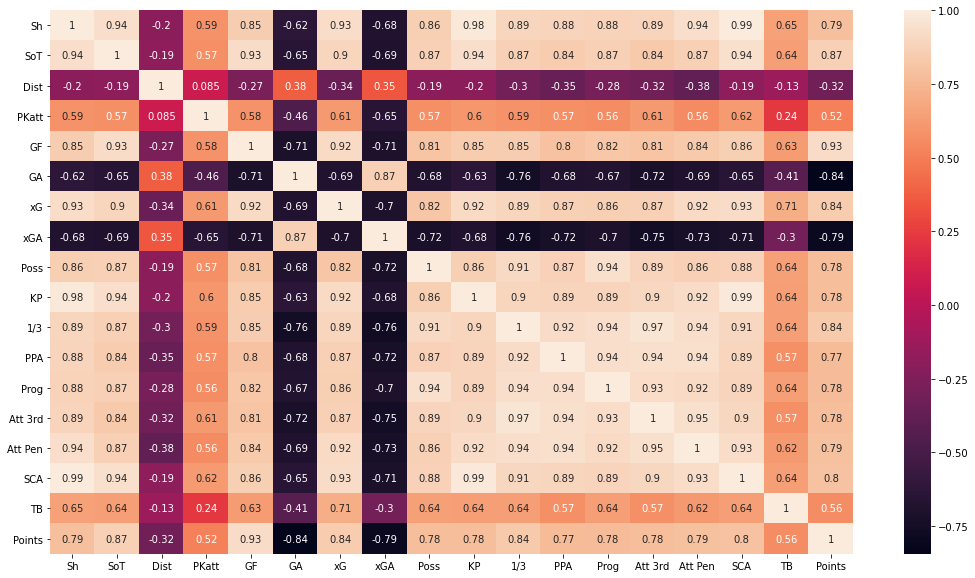

In [323]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(total.drop(['CrsPA','Season','Team','FK','PK','Points per match'],axis=1).corr(),annot=True,)

So pretty much all features have a great correlation with number of points. I am not interested in goals scored and allowed because it is obvious that they would influence wins. Goal creation stats like xG, KP, Prog, PPA have a good correlation with points which is great for us.

Let's do Machine Learning and try to predict points for current season finale.

In [24]:
X=total.drop(['Points','Season','Team','Points per match'],axis=1)
y=total['Points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
seas22_test=seas22.drop(['Points','Season','Team','Points per match'],axis=1)

In [25]:
knn = KNeighborsRegressor(n_neighbors=8)
dt  = DecisionTreeRegressor(max_depth = 5)
rf  = RandomForestRegressor(n_estimators=100, max_features= 7)
ada = AdaBoostRegressor( n_estimators=150, learning_rate =.08)
gbr = GradientBoostingRegressor(max_depth=7, n_estimators=500, learning_rate =.05)
xgb = XGBRegressor(max_depth = 7, n_estimators=500, learning_rate =.05)
cb  = CatBoostRegressor(learning_rate =.07, max_depth =7, verbose=0)

regressors = [('K Nearest Neighbours', knn),('Decision Tree', dt), ('Random Forest', rf), 
              ('AdaBoost', ada),('Gradient Boosting Regressor', gbr),('XGBRegressor', xgb),('CatBoostRegressor', cb)]

K Nearest Neighbours : 68 %
Decision Tree : 84 %
Random Forest : 90 %
AdaBoost : 93 %
Gradient Boosting Regressor : 88 %
XGBRegressor : 93 %
CatBoostRegressor : 82 %


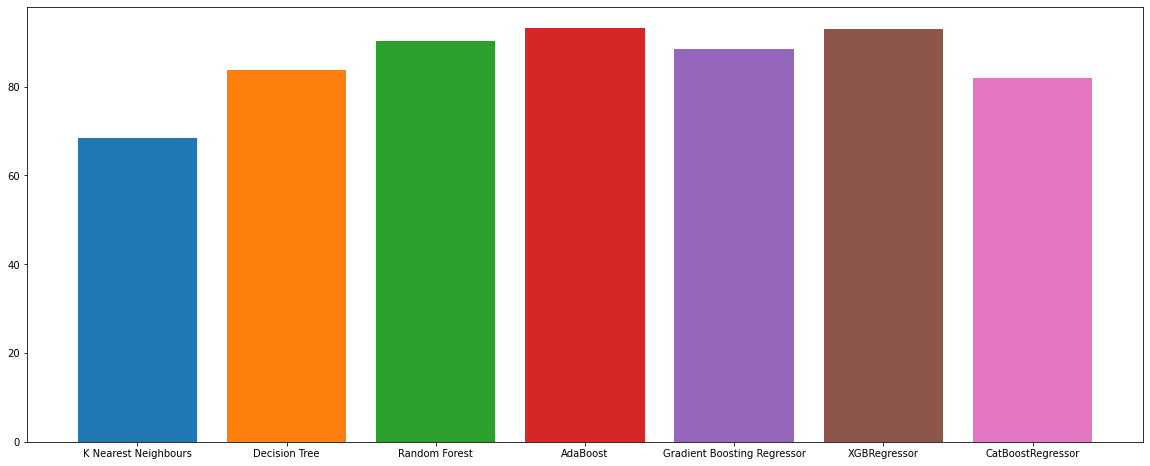

In [26]:
for regressor_name, regressor in regressors:

    regressor.fit(X_train, y_train)    
  
    y_pred = regressor.predict(X_test)
    accuracy = round(r2_score(y_test,y_pred),3)*100
    
    print('{:s} : {:.0f} %'.format(regressor_name, accuracy))
    plt.rcParams["figure.figsize"] = (20,8)
    plt.bar(regressor_name,accuracy)

Seems like XGBRegressor, AdaBoost and Random Forest showed the best results, I will predict the number of points using these three regressors.

In [95]:
seas22_copy=seas22
for regressor_name, regressor in regressors:
    
    y_pred = regressor.predict(seas22_test)
    seas22_copy[regressor_name]=y_pred
    seas22_copy[f"{regressor_name} PPg"]=y_pred/38
    
    

In [96]:
seas22_copy.drop(['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'GF', 'GA', 'xG',
       'xGA', 'Poss', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog', 'Att 3rd',
       'Att Pen', 'SCA', 'TB'],axis=1,inplace=True)

In [97]:
seas22_copy

,Team,Season,Points,Points per match,K Nearest Neighbours,K Nearest Neighbours PPg,Decision Tree,Decision Tree PPg,Random Forest,Random Forest PPg,AdaBoost,AdaBoost PPg,Gradient Boosting Regressor,Gradient Boosting Regressor PPg,XGBRegressor,XGBRegressor PPg,CatBoostRegressor,CatBoostRegressor PPg
0,Arsenal,2022,37,2.642857,78.625,2.069079,81.000000,2.131579,84.40,2.221053,94.142857,2.477444,93.807049,2.468607,97.064796,2.554337,86.113803,2.266153
1,Manchester City,2022,32,2.285714,82.750,2.177632,75.000000,1.973684,85.83,2.258684,84.333333,2.219298,73.077166,1.923083,88.151802,2.319784,85.209557,2.242357
2,Newcastle United,2022,30,2.000000,62.500,1.644737,81.000000,2.131579,73.10,1.923684,72.555556,1.909357,88.827047,2.337554,78.422432,2.063748,76.650310,2.017113
3,Tottenham Hotspur,2022,29,1.933333,50.125,1.319079,68.875000,1.812500,65.13,1.713947,64.687500,1.702303,66.822576,1.758489,63.367584,1.667568,61.274189,1.612479
4,Manchester United,2022,26,1.857143,56.500,1.486842,47.300000,1.244737,56.13,1.477105,51.100000,1.344737,45.494068,1.197212,47.476658,1.249386,52.505267,1.381718
5,Liverpool,2022,22,1.571429,78.625,2.069079,75.000000,1.973684,79.27,2.086053,73.333333,1.929825,73.349467,1.930249,70.071175,1.843978,71.310219,1.876585
6,Brighton and Hove Albion,2022,21,1.500000,68.625,1.805921,68.875000,1.812500,68.79,1.810263,67.750000,1.782895,68.100664,1.792123,63.690033,1.676054,67.972261,1.788744
7,Chelsea,2022,21,1.500000,68.625,1.805921,57.142857,1.503759,55.90,1.471053,52.615385,1.384615,56.242046,1.480054,56.452412,1.485590,55.326202,1.455953
8,Fulham,2022,19,1.266667,47.625,1.253289,52.000000,1.368421,46.68,1.228421,47.687500,1.254934,53.975199,1.420400,43.533638,1.145622,48.870489,1.286065
9,Brentford,2022,19,1.266667,41.250,1.085526,68.875000,1.812500,47.91,1.260789,49.444444,1.301170,65.812455,1.731907,46.140198,1.214216,49.973848,1.315101


What we see here is the points gained with current averages of features but it didn't take in consideration current points of the teams. So I calculated how many points the teams have per game in this completely predicted season, I multiplied this points per game number by the number of the left games in the season and added current number of points.

In [77]:
seas22_copy['Predicted Points XGB']=0.0
for i in range(len(seas22_copy['Team'].unique())):
    seas22_copy['Predicted Points XGB'][i]=seas22_copy['XGBRegressor PPg'][i]*(38-len(fix[(fix['Team']==seas22_copy['Team'][i])&(fix['Season']==2022)]))+seas22_copy['Points'][i]

<ipython-input-77-ec8ec6b32e0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seas22_copy['Predicted Points XGB'][i]=seas22_copy['XGBRegressor PPg'][i]*(38-len(fix[(fix['Team']==seas22_copy['Team'][i])&(fix['Season']==2022)]))+seas22_copy['Points'][i]


In [78]:
seas22_copy['Predicted Points AdaBoost']=0.0
for i in range(len(seas22_copy['Team'].unique())):
    seas22_copy['Predicted Points AdaBoost'][i]=seas22_copy['AdaBoost PPg'][i]*(38-len(fix[(fix['Team']==seas22_copy['Team'][i])&(fix['Season']==2022)]))+seas22_copy['Points'][i]

<ipython-input-78-7b3dea184dd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seas22_copy['Predicted Points AdaBoost'][i]=seas22_copy['AdaBoost PPg'][i]*(38-len(fix[(fix['Team']==seas22_copy['Team'][i])&(fix['Season']==2022)]))+seas22_copy['Points'][i]


In [79]:
seas22_copy['Predicted Points Random Forest']=0.0
for i in range(len(seas22_copy['Team'].unique())):
    seas22_copy['Predicted Points Random Forest'][i]=seas22_copy['Random Forest PPg'][i]*(38-len(fix[(fix['Team']==seas22_copy['Team'][i])&(fix['Season']==2022)]))+seas22_copy['Points'][i]

<ipython-input-79-89fd23e29bd4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seas22_copy['Predicted Points Random Forest'][i]=seas22_copy['Random Forest PPg'][i]*(38-len(fix[(fix['Team']==seas22_copy['Team'][i])&(fix['Season']==2022)]))+seas22_copy['Points'][i]


In [81]:
seas22_1=seas22_copy

In [84]:
seas22_1[['Predicted Points XGB','Predicted Points AdaBoost','Predicted Points Random Forest']]=seas22_1[['Predicted Points XGB','Predicted Points AdaBoost','Predicted Points Random Forest']].astype(int)

Let's see one by one the final tables for current season in three versions of those three regressors that peformed the best.

In [101]:
seas22_1.sort_values('Predicted Points XGB',ascending=False)[['Team','Season','Predicted Points XGB']]

,Team,Season,Predicted Points XGB
0,Arsenal,2022,98
1,Manchester City,2022,87
2,Newcastle United,2022,77
3,Tottenham Hotspur,2022,67
5,Liverpool,2022,66
6,Brighton and Hove Albion,2022,61
7,Chelsea,2022,56
4,Manchester United,2022,55
10,Crystal Palace,2022,51
14,Leeds United,2022,47


In [102]:
seas22_1.sort_values('Predicted Points AdaBoost',ascending=False)[['Team','Season','Predicted Points AdaBoost']]

,Team,Season,Predicted Points AdaBoost
0,Arsenal,2022,96
1,Manchester City,2022,85
2,Newcastle United,2022,73
3,Tottenham Hotspur,2022,68
5,Liverpool,2022,68
6,Brighton and Hove Albion,2022,63
4,Manchester United,2022,58
7,Chelsea,2022,54
14,Leeds United,2022,52
12,Leicester City,2022,49


In [103]:
seas22_1.sort_values('Predicted Points Random Forest',ascending=False)[['Team','Season','Predicted Points Random Forest']]

,Team,Season,Predicted Points Random Forest
0,Arsenal,2022,90
1,Manchester City,2022,86
2,Newcastle United,2022,74
5,Liverpool,2022,72
3,Tottenham Hotspur,2022,68
6,Brighton and Hove Albion,2022,64
4,Manchester United,2022,61
7,Chelsea,2022,56
14,Leeds United,2022,50
10,Crystal Palace,2022,49


So the picture is almost the same, Arsenal finishes first having 90+ points. Newcastle finishes 3rd in all cases due to current good performance stats of this team. Due to the same reason teams like Chelsea and Manchester United finish poorly in the prediction although in reality at this stage of the season Manchester United is higher than Brighton and Liverpool. Probably overachieving number of points in current stage of the season for Arsenal and Newcastle allow them to finish high in the prediction. Well, Arsenal have good performance averages too, something near to championship level per game stats, this and already gained points help them to win the title in the prediction. Again the pressing quality stats might improve prediction and team like Manchester City, which is one of the best if not the best team in pressing quality, would win the title in simulation. 